## Because the vote fraction $f_{features}$ tends to drop heavily at high redshift and low surface brightness, we are likely incomplete in our sample of disks at these regions. We'll use the simulated FERENGI images to apply a multiplicitave correction to the number of disks we detect at a given z and $\mu$. 

In [40]:
%pylab inline
import matplotlib.gridspec as gridspec
from astropy.table import Table,Column
import numpy as np
import matplotlib.pyplot as plt
from operator import itemgetter
import os
from astropy.cosmology import WMAP9 
import requests


from PIL import Image
import urllib, cStringIO
import random

#function for getting galaxy images
def get_image_from_url(url):

    file = cStringIO.StringIO(urllib.urlopen(url).read())
    img = Image.open(file)
    return img


mpl.rcParams['text.usetex']=True
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.labelsize'] = 20 


Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [2]:
#The data: Contains 'best' vote fractions for the FERENGI data. See ferengi_debiased_votes.ipynb for details.
data=Table.read('../data/ferengi_debiased_nuv_J.fits')

In [3]:
#use criteria from galex_ferengi.ipynb to split ferengi into red sequence and blue cloud
red_sequence = data[(data['nuv_mag']-data['r']>3.1)]
blue_cloud = data[(data['nuv_mag']-data['r']<3.1)]


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in less
  app.launch_new_instance()


/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


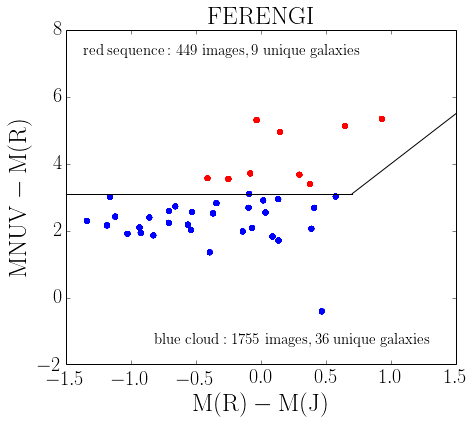

In [4]:
f=plt.figure(figsize=(7,6))

x1=np.linspace(-5,.7,100)
x2=np.linspace(.7,5,100)

plt.plot(x1,3.1+0*x1,c='k')
plt.plot(x2,3*x2+1,c='k')

plt.scatter(red_sequence['r']-red_sequence['j'],red_sequence['nuv_mag']-red_sequence['r'],color='r')
plt.scatter(blue_cloud['r']-blue_cloud['j'],blue_cloud['nuv_mag']-blue_cloud['r'],color='b')

plt.xlim(-1.5,1.5)
plt.ylim(-2,8)
plt.ylabel('$\mathrm{MNUV-M(R)}$',fontsize=25)
plt.xlabel('$\mathrm{M(R)-M(J)}$',fontsize=25)
f.text(.16,.84,r'$\mathrm{red~sequence:%i~images, %i~unique~galaxies}$'%(len(red_sequence),len(set(red_sequence['sdss_id']))),fontsize=15)
f.text(.3,.17,r'$\mathrm{blue~cloud:%i~images, %i~unique~galaxies}$'%(len(blue_cloud),len(set(blue_cloud['sdss_id']))),fontsize=15)
plt.title('$\mathrm{FERENGI}$',fontsize=25)


In [5]:
#Dictionary to store f_features data for each galaxy, imaged at z=0.3 ('lo') and z = z ('hi')
#define edges of surface brightness bins
yedges=np.linspace(np.min(data['GZ_MU_I']),np.max(data['GZ_MU_I']),6)
yedges=[round(y,2) for y in yedges]

#define edges of simulated redshift bins
xedges=np.linspace(np.min(data['sim_redshift'])-.05,np.max(data['sim_redshift'])+.05,9)
xedges=[round(x,2) for x in xedges]

red_scatter_dct={}
for i in range(0,len(xedges)-1):
    for j in range(0,len(yedges)-1):
        red_scatter_dct[xedges[i],xedges[i+1],yedges[j],yedges[j+1],'hi']=[]
        red_scatter_dct[xedges[i],xedges[i+1],yedges[j],yedges[j+1],'lo']=[]
        red_scatter_dct[xedges[i],xedges[i+1],yedges[j],yedges[j+1],'subj_id']=[]
blue_scatter_dct={}
for i in range(0,len(xedges)-1):
    for j in range(0,len(yedges)-1):
        blue_scatter_dct[xedges[i],xedges[i+1],yedges[j],yedges[j+1],'hi']=[]
        blue_scatter_dct[xedges[i],xedges[i+1],yedges[j],yedges[j+1],'lo']=[]
        blue_scatter_dct[xedges[i],xedges[i+1],yedges[j],yedges[j+1],'subj_id']=[]


red_galaxies = set(red_sequence['sdss_id']) #set unique red galaxies 
blue_galaxies = set(blue_cloud['sdss_id']) #set unique red galaxies 

In [6]:
xedges

[0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95, 1.05]

In [7]:
#fill in scatter_dct
p_x = 't01_smooth_or_features_a02_features_or_disk_best_fraction'

#red
for i,g in enumerate(red_galaxies):
    this_gal=(red_sequence['sdss_id']==g)
    evos = set(red_sequence[this_gal]['sim_evolution'])
    for e in evos:
        this_evo=(red_sequence[this_gal]['sim_evolution']==e)
        if len(set(red_sequence[this_gal][this_evo]['sim_redshift']))==8: #only want stuff where we have data down to 0.3
            p_at_3=(red_sequence[this_gal][this_evo]['sim_redshift']==.3)
            p_x_at_3 = red_sequence[this_gal][this_evo][p_at_3][p_x][0]#value of p_x at redshift 0.3
            for row in red_sequence[this_gal][this_evo]:
                for y in range(0,len(yedges)-1):
                    for x in range(0,len(xedges)-1):
                        if row['sim_redshift']>xedges[x] and row['sim_redshift'] < xedges[x+1] and row['GZ_MU_I'] > yedges[y] and row['GZ_MU_I'] < yedges[y+1]: #now look at high redshift data
                            red_scatter_dct[xedges[x],xedges[x+1],yedges[y],yedges[y+1],'hi'].append(row[p_x]) # slap p_x in high list 
                            red_scatter_dct[xedges[x],xedges[x+1],yedges[y],yedges[y+1],'lo'].append(p_x_at_3) # put z=0.3 value in low list 

#blue
for i,g in enumerate(blue_galaxies):
    this_gal=(blue_cloud['sdss_id']==g)
    evos = set(blue_cloud[this_gal]['sim_evolution'])
    for e in evos:
        this_evo=(blue_cloud[this_gal]['sim_evolution']==e)
        if len(set(blue_cloud[this_gal][this_evo]['sim_redshift']))==8: #only want stuff where we have data down to 0.3
            p_at_3=(blue_cloud[this_gal][this_evo]['sim_redshift']==.3)
            p_x_at_3 = blue_cloud[this_gal][this_evo][p_at_3][p_x][0]#value of p_x at redshift 0.3
            for row in blue_cloud[this_gal][this_evo]:
                for y in range(0,len(yedges)-1):
                    for x in range(0,len(xedges)-1):
                        if row['sim_redshift']>xedges[x] and row['sim_redshift'] < xedges[x+1] and row['GZ_MU_I'] > yedges[y] and row['GZ_MU_I'] < yedges[y+1]: #now look at high redshift data
                            blue_scatter_dct[xedges[x],xedges[x+1],yedges[y],yedges[y+1],'hi'].append(row[p_x]) # slap p_x in high list 
                            blue_scatter_dct[xedges[x],xedges[x+1],yedges[y],yedges[y+1],'lo'].append(p_x_at_3) # put z=0.3 value in low list 


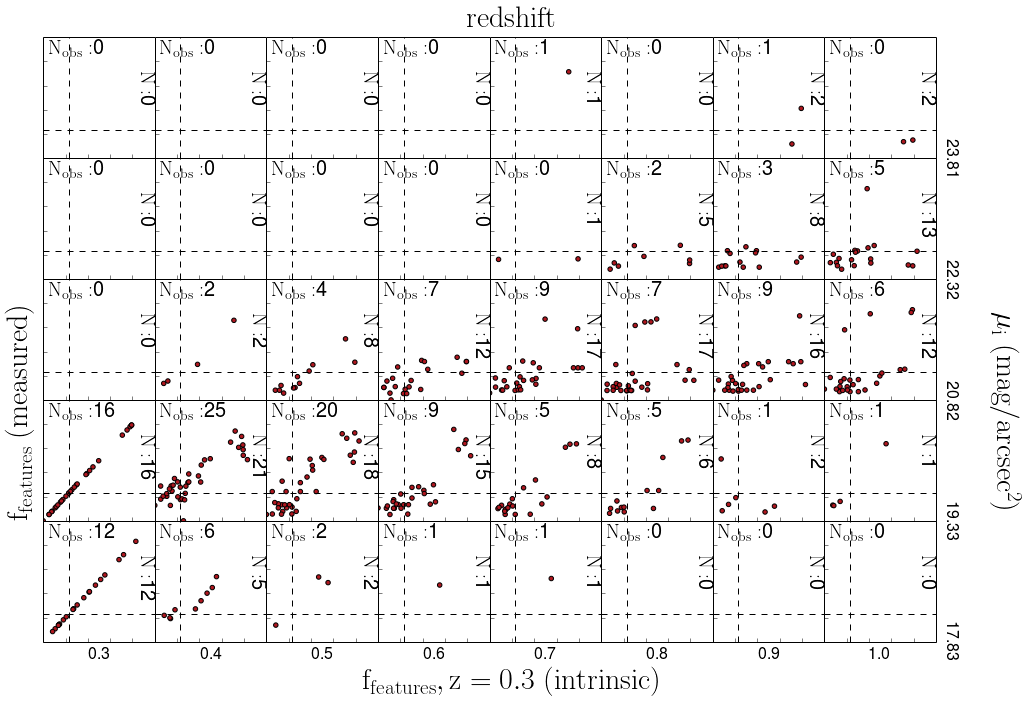

In [8]:
#plot 
f=figure(figsize=(20,13))
x_new = np.linspace(0,.95,40)

disk_cut = .23
completion_matrix = np.zeros(shape=(len(xedges)-1,len(yedges)-1))

gs=gridspec.GridSpec(len(yedges),len(xedges)+1)
gs.update(wspace=0)
gs.update(hspace=0)
yedge_int=np.linspace(0,len(yedges)-2,len(yedges)-1)
yedge_int=[int(y) for y in yedge_int]
yedge_int=yedge_int[::-1]
y_label=[]
x_label=[]
facecolors=['#af8dc3','#999999','#7fbf7b']
for i in range(0,len(yedges)-1):
    y_label.append(round((yedges[i]+yedges[i+1])/2,2))
y_label=y_label[::-1]
for i in range(0,len(xedges)-1):
    x_label.append(round((xedges[i]+xedges[i+1])/2,2))

for y in range(0,len(yedges)-1):
    for x in range(0,len(xedges)-1):
        ax=plt.subplot(gs[yedge_int[y],x])
        xs=red_scatter_dct[xedges[x],xedges[x+1],yedges[y],yedges[y+1],'lo']
        ys=red_scatter_dct[xedges[x],xedges[x+1],yedges[y],yedges[y+1],'hi']

        plt.axhline(disk_cut,ls='dashed',c='k')
        plt.axvline(disk_cut,ls='dashed',c='k')
        #calculate number of observed disks
        disks_observed = sum(i>=disk_cut for i in ys) 
        disks_actual = sum(i>=disk_cut for i in xs)

        completion_matrix.T[y,x]=(float(disks_observed)/disks_actual) if len(xs)>10 and disks_actual > 0 else 'nan'

        
        ax.text(.05,.84,'$\mathrm{N_{obs}:}$%s'%disks_observed,fontsize=20)
        ax.text(.83,.6,'$\mathrm{N:}$%s'%disks_actual,rotation=270,fontsize=20)

        plt.scatter(xs,ys,c='#B0171F',marker='o',edgecolors='k')

        plt.tick_params(labelleft='off')
        plt.tick_params(top='off',right='off',labelbottom='off')
        plt.xlim(0,1)
        plt.ylim(0,1)
        if y==0:
            plt.xlabel('%s'%str(x_label[x]),fontsize=16)

        if x==7:
            ax.yaxis.set_label_position("right")
            plt.ylabel('%s'%str(yedges[y]),fontsize=16,rotation=270)
            ax.yaxis.set_label_coords(1.2, 0)
    


f.text(.78,.5,r'$\mathrm{\mu_{i}~(mag/arcsec^2)}$',rotation=270,fontsize=30,va='center')
f.text(.45,.91,r'$\mathrm{redshift}$',fontsize=30,ha='center')
f.text(.1,.5,r'$\mathrm{f_{features}~(measured)}$',rotation=90,fontsize=30,va='center')
f.text(.45,.2,r'$\mathrm{f_{features},z=0.3~(intrinsic)}$',fontsize=30,ha='center')

#plt.savefig('Images/red_ferengi_corrected_debiased.png')

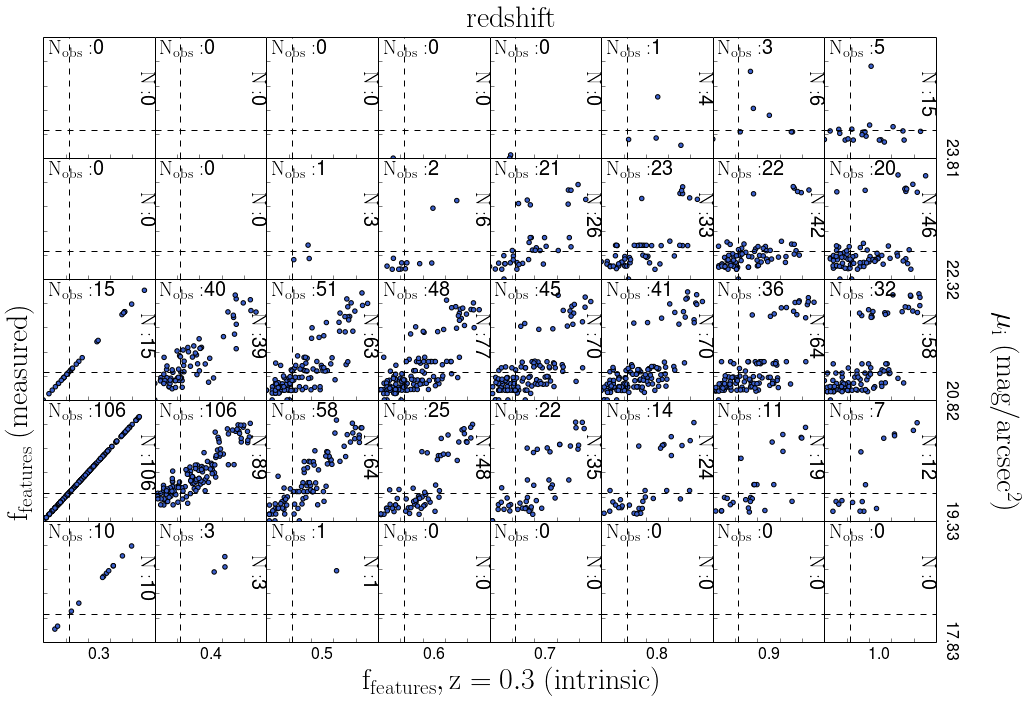

In [9]:
#plot 
f=figure(figsize=(20,13))
x_new = np.linspace(0,.95,40)

disk_cut = .23
blue_completion_matrix = np.zeros(shape=(len(xedges)-1,len(yedges)-1))

gs=gridspec.GridSpec(len(yedges),len(xedges)+1)
gs.update(wspace=0)
gs.update(hspace=0)
yedge_int=np.linspace(0,len(yedges)-2,len(yedges)-1)
yedge_int=[int(y) for y in yedge_int]
yedge_int=yedge_int[::-1]
y_label=[]
x_label=[]
facecolors=['#af8dc3','#999999','#7fbf7b']
for i in range(0,len(yedges)-1):
    y_label.append(round((yedges[i]+yedges[i+1])/2,2))
y_label=y_label[::-1]
for i in range(0,len(xedges)-1):
    x_label.append(round((xedges[i]+xedges[i+1])/2,2))

for y in range(0,len(yedges)-1):
    for x in range(0,len(xedges)-1):
        ax=plt.subplot(gs[yedge_int[y],x])
        xs=blue_scatter_dct[xedges[x],xedges[x+1],yedges[y],yedges[y+1],'lo']
        ys=blue_scatter_dct[xedges[x],xedges[x+1],yedges[y],yedges[y+1],'hi']

        plt.axhline(disk_cut,ls='dashed',c='k')
        plt.axvline(disk_cut,ls='dashed',c='k')
        #calculate number of observed disks
        disks_observed = sum(i>=disk_cut for i in ys) 
        disks_actual = sum(i>=disk_cut for i in xs)

        blue_completion_matrix.T[y,x]=(float(disks_observed)/disks_actual) if len(xs)>10 and disks_actual > 0 else 'nan'

        
        ax.text(.05,.84,'$\mathrm{N_{obs}:}$%s'%disks_observed,fontsize=20)
        ax.text(.83,.6,'$\mathrm{N:}$%s'%disks_actual,rotation=270,fontsize=20)

        plt.scatter(xs,ys,c='#3A5FCD',marker='o',edgecolors='k')

        plt.tick_params(labelleft='off')
        plt.tick_params(top='off',right='off',labelbottom='off')
        plt.xlim(0,1)
        plt.ylim(0,1)
        if y==0:
            plt.xlabel('%s'%str(x_label[x]),fontsize=16)

        if x==7:
            ax.yaxis.set_label_position("right")
            plt.ylabel('%s'%str(yedges[y]),fontsize=16,rotation=270)
            ax.yaxis.set_label_coords(1.2, 0)
    


f.text(.78,.5,r'$\mathrm{\mu_{i}~(mag/arcsec^2)}$',rotation=270,fontsize=30,va='center')
f.text(.45,.91,r'$\mathrm{redshift}$',fontsize=30,ha='center')
f.text(.1,.5,r'$\mathrm{f_{features}~(measured)}$',rotation=90,fontsize=30,va='center')
f.text(.45,.2,r'$\mathrm{f_{features},z=0.3~(intrinsic)}$',fontsize=30,ha='center')

#plt.savefig('Images/red_ferengi_corrected_debiased.png')

<matplotlib.colorbar.Colorbar instance at 0x7f52a127ecf8>

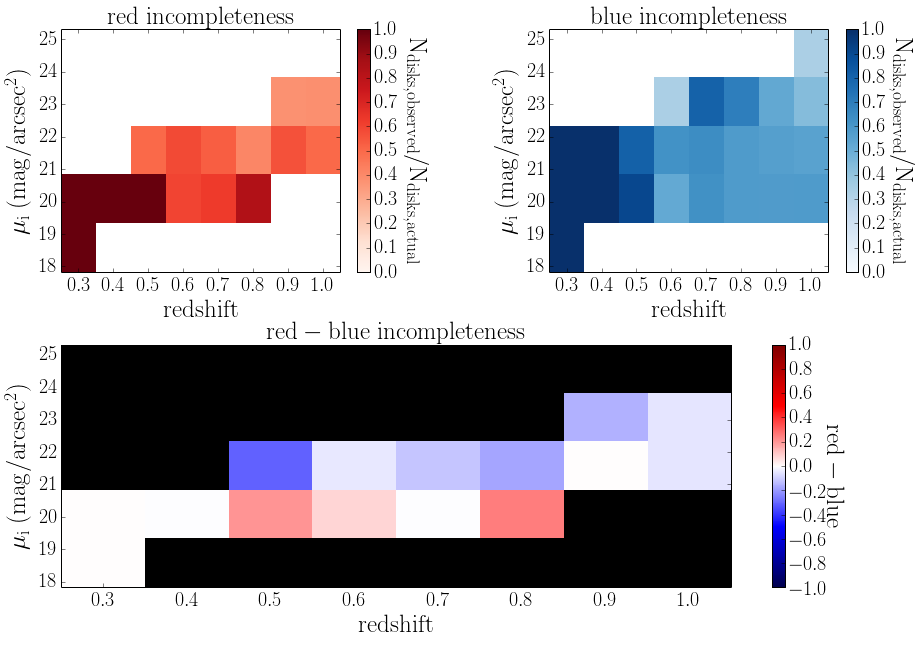

In [69]:
f=plt.figure(figsize=(15,10))
gs = gridspec.GridSpec(2,2)
gs.update(wspace=.4,hspace=.3)
extent=[xedges[0],xedges[-1],yedges[0],yedges[-1]]
ax=plt.subplot(gs[0,0])
plt.imshow(completion_matrix.T,origin='lower',extent=extent,interpolation='nearest',vmin=0,vmax=1,cmap=cm.Reds,aspect='auto')
plt.xlim(.25,1.05)
plt.title('$\mathrm{red~incompleteness}$',fontsize=25)
plt.xlabel('$\mathrm{redshift}$',fontsize=25)
plt.ylabel('$\mathrm{\mu_{i}~(mag/arcsec^2)}$',fontsize=25)
f.text(.44,.73,r'$\mathrm{N_{disks,observed}/N_{disks,actual}}$',rotation=270,fontsize=25,va='center')
plt.colorbar()
ax=plt.subplot(gs[0,1])
plt.imshow(blue_completion_matrix.T,origin='lower',extent=extent,interpolation='nearest',vmin=0,vmax=1,cmap=cm.Blues,aspect='auto')
plt.xlim(.25,1.05)
plt.title('$\mathrm{blue~incompleteness}$',fontsize=25)
plt.xlabel('$\mathrm{redshift}$',fontsize=25)
plt.ylabel('$\mathrm{\mu_{i}~(mag/arcsec^2)}$',fontsize=25)
f.text(.89,.73,r'$\mathrm{N_{disks,observed}/N_{disks,actual}}$',rotation=270,fontsize=25,va='center')
plt.colorbar()
ax=plt.subplot(gs[1,:])
cmap = cm.seismic
cmap.set_bad(color = 'k', alpha = 1.)
comparison_matrix = completion_matrix-blue_completion_matrix
plt.imshow(comparison_matrix.T,origin='lower',extent=extent,vmin=-1,vmax=1,interpolation='nearest',cmap=cmap,aspect='auto')
plt.xlim(.25,1.05)
plt.title('$\mathrm{red-blue~incompleteness}$',fontsize=25)
plt.xlabel('$\mathrm{redshift}$',fontsize=25)
plt.ylabel('$\mathrm{\mu_{i}~(mag/arcsec^2)}$',fontsize=25)
f.text(.83,.28,r'$\mathrm{red-blue}$',rotation=270,fontsize=25,va='center')
plt.colorbar()

Bottom plot: red incompleteness - blue incompleness. Red means the completeness is greater for the red galaxies; that is, the number of observed red galaxies matches the actual number of red galaxies better than the number of observed blue galaxies matches the number of actual blue galaxies. 

The above plot shows that for brighter galaxies, the number of red galaxies detected is truer to the actual value. For dimmer galaxies, the number of blue galaxies detected is truer to the actual value. 

In [77]:
mnuv: .23 um
r: .623 um
j: 1.2 um
    
sloan:
u: .354
r: .622
z: .905

9

(0, 3)

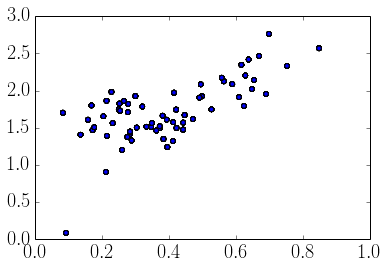

In [96]:
plt.scatter(data['r']-data['z'],data['u']-data['r'])
plt.xlim(0,1)
plt.ylim(0,3)

In [41]:
plt.imshow(get_image_from_url(red_sequence[0]['location_thumbnail']))

IOError: [Errno socket error] [Errno 1] _ssl.c:510: error:14077410:SSL routines:SSL23_GET_SERVER_HELLO:sslv3 alert handshake failure

In [31]:
red_sequence[0]['location_standard']

'http://www.galaxyzoo.org/subjects/standard/5249ce0c3ae74072a300355b.jpg'

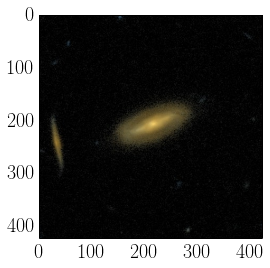

In [38]:
plt.imshow(get_image_from_url('http://zoo-hst.s3.amazonaws.com/20000669.jpg'))